In [ ]:
# Install dependencies
! pip install tensorflow_hub tensorflow_text
pip install pyLDAvis

In [1]:
pip install pyLDAvis

     |████████████████████████████████| 1.7MB 5.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.3MB 233kB/s 
     |████████████████████████████████| 9.9MB 36.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-cp37-none-any.whl size=136897 sha256=d34206ddf379b93c8a235b126624d9fd54e419c5f9acbe7e3b399d3d475b590a
  Stored in directory: /root/.cache/pip/wheels/a0/9c/fc/c6e00689d35c82cf96a8adc70edfe7ba7904374fdac3240ac2
Successfully built pyLDAvis
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.20.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0

In [2]:
#Importing relevant packages 

import numpy as np
import pandas as pd 
import ast

#Importing NLTK and NLP packages
import nltk
from nltk.tokenize import TweetTokenizer
import string
import re
from collections import defaultdict
from collections import Counter

#Importing packages for data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

#Importing packages for LDA
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import ClippedCorpus
from gensim.models import CoherenceModel


#for preprocessing
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#for visualisation
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [17]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load dataset
path_2_data = '/content/drive/MyDrive/FCTurbine/preprocessed_tweets_with_language.csv'
df = pd.read_csv(path_2_data)

#only english tweets
df = df[df['EnglishTweet'] == 1]
 
#clean nan values, use clean tweets with no retweets
df = df[pd.notna(df['tweet_cleaned_no_rt'])]

# subsample data, stratified by user (to ensure we don't accidentally get a sample consisting of only a handful of users)
df = df.groupby('username').apply(lambda x: x.sample(random_state = 42, frac =0.5)).reset_index(drop=True)

In [ ]:
print('Number of Users: ', len(df.username.unique()))
print('Number of tweets in sample: ', len(df))

Number of Users:  172
Number of tweets in sample:  48069


# Pre-processing

In [ ]:
#list for saving tokenised pre processed tweets
unigrams =[]

#lemmatise 
lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')

#loop through tweets of df
for s in df.tweet_cleaned:
  #remove url 
  s = re.sub(r'http://\S+|https://\S+','',s)
  #remove usernames
  s = re.sub('@[\w]+','', s)
  #remove digits
  s = re.sub('[0-9]', '', s)
  # lowercase
  s = s.lower() 
  #remove punctuation
  s = re.sub(r'[^\w\s]','',s)
  #tokenise
  s = s.split()
  #remove stopwords
  s = [item for item in s if item not in stop]
  #lemmatise - move up??? needs cleaning
  s = [lemmatizer.lemmatize(item) for item in s]
  unigrams.append(s)

In [ ]:
#append unigrams (tokenised tweets) to df
df['unigrams'] = unigrams

In [ ]:
#creating bigrams from unigrams, append to df
bigrams = []

for s in df.unigrams:
  try:
    bi_tweet = []
    bigram = list(nltk.bigrams(s))
    for item in bigram:
      bi_tweet.append('_'.join(item))
    bigrams.append(bi_tweet)
  except RuntimeError as e:
    bigrams.append(s)

df['bigrams'] = bigrams

In [ ]:
#Combining unigrams and bigrams in one column
df['tokens'] = df.unigrams+df.bigrams

In [ ]:
df = df.dropna()
print('Final sample: ', len(df))

Final sample:  48054


In [ ]:
#df grouped by accounts
df_g = df[['username', 'unigrams', 'bigrams', 'tokens']].groupby('username', as_index = False).sum()

In [ ]:
df_g.head()

,username,unigrams,bigrams,tokens
0,1FELLS,"[behind, wind, turbine, war, lack, policy, joi...","[behind_wind, wind_turbine, turbine_war, war_l...","[behind, wind, turbine, war, lack, policy, joi..."
1,2bridgesfarm,"[upcoming, webinar, mobile, abattoir, provinci...","[upcoming_webinar, webinar_mobile, mobile_abat...","[upcoming, webinar, mobile, abattoir, upcoming..."
2,AroostookWind,"[american, bird, conservancy, make, wind, powe...","[american_bird, bird_conservancy, conservancy_...","[american, bird, conservancy, make, wind, powe..."
3,BWindAware,"[need, advice, submission, bord, pleanala, ask...","[need_advice, advice_submission, submission_bo...","[need, advice, submission, bord, pleanala, ask..."
4,Barbarajdurkin,"[orsted, blade, fail, year, operation, blade, ...","[orsted_blade, blade_fail, fail_year, year_ope...","[orsted, blade, fail, year, operation, blade, ..."


In [ ]:
#descriptives: average document length
from statistics import mean

print('Average tokens per document (single tweet): ', df.tokens.apply(len).mean())
print('Number of documents: ', len(df))

print('\n')

print('Average tokens per document (grouped by user): ', df_g.tokens.apply(len).mean())
print('Number of documents: ', len(df_g))

#calculate average number of documents per user
average = 0

for name in df.username.unique():
  average += len(df[df['username'] == name])

average = average / len(df_g)
print('Average documents per user: ', average )

Average tokens per document (single tweet):  16.91476255878803
Number of documents:  48054


Average tokens per document (grouped by user):  4725.709302325581
Number of documents:  172
Average documents per user:  279.3837209302326


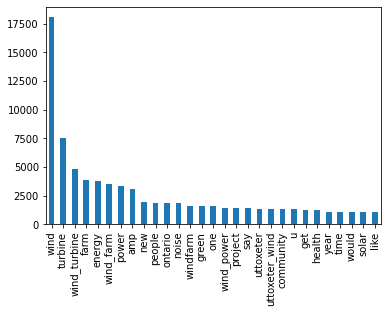

In [ ]:
#combine tokens
all_tokens = df.tokens.to_list()
all_tokens_de_nested = [y for x in all_tokens for y in x]
#count tokens
frequency_of_terms = nltk.FreqDist(all_tokens_de_nested) 
df_freq = pd.DataFrame(dict(frequency_of_terms), index = [0]) \
                        .transpose()                          \
                        .rename(columns={0:'Count'})          \
                        .sort_values('Count', ascending=False) #formatting
#plot token frequency
df_freq.loc[df_freq['Count']>1000, 'Count'].plot.bar()
plt.xticks(rotation=90)
plt.show()

In [ ]:
#write updated df to csv
df.to_csv('/content/drive/MyDrive/FCTurbine/for_lda.csv')

In [ ]:
#write account df to csv
df_g.to_csv('/content/drive/MyDrive/FCTurbine/grouped_df.csv')

# hSBM set up

In [ ]:
# install dependencies
!pip install -q condacolab
import condacolab
condacolab.install()
 
import condacolab
#condacolab.check()
 
! conda config --add channels conda-forge
! conda config --add channels ostrokach-forge
! conda config --add channels pkgw-forge
 
! conda install gtk3 
! conda install pygobject graph-tool cairo
! conda install -c conda-forge graph-tool 
! git clone https://github.com/martingerlach/hSBM_Topicmodel.git

import graph_tool.all as gt

from hSBM_Topicmodel.sbmtm import sbmtm

✨🍰✨ Everything looks OK!
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

# All requested packages already installed.

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

# All requested packages already installed.

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

# All requested packages already installed.

fatal: destination path 'hSBM_Topicmodel' already exists and is not an empty directory.


**Helper Functions**

In [ ]:
#remove infrequent words (words used less than 5 times)

def infrequent(docs):
  c = Counter()

  #loop through sample, only save words that occur more than 5 times
  for doc in docs:
      c.update(Counter(doc))

  vocab = c.most_common(25000)

  vocab = set([w for w,count in vocab if count>5])

  # remove words
  docs = [[w for w in doc if w in vocab] for doc in docs]

  return docs

In [ ]:
#make df of words in topics in first hierarchy
def level_to_df(level):

  data = []
  for i in level:
    words = [x[0] for x in level[i]]
    data.append(' ,'.join(words))

  return pd.DataFrame(data, columns = ['Topics'])

# hSBM (per tweet)

In [ ]:
#docs to use in hSBM: per tweet, unigrams +bigrams
docs = df.tokens.values

In [ ]:
#remove infrequent words
docs = infrequent(docs)

In [ ]:
#create an instance of the sbmtm-class
model = sbmtm()

#create the word-document network from the corpus
model.make_graph(docs)

# fit the model
gt.seed_rng(32) ## seed for graph-tool's random number generator --> same results
model.fit()

In [ ]:
# Inspect topics.
topics = model.topics()
topics

In [ ]:
#save topics to csv
import csv
with open('tweet_topics.csv', 'w') as f:
    for key in topics.keys():
        f.write("%s,%s\n"%(key,topics[key]))

In [ ]:
#save topics in the first level hierarchy 
first_level_tweets = model.topics(l=1,n=10)

In [ ]:
#make df from first level topics
tweet_level = level_to_df(first_level_tweets)

#save to csv
tweet_level.to_csv('tweets_first_level.csv')

# hSBM-U (user aggregated)

In [ ]:
#docs to use in hSBM-U: user aggregated, unigrams +bigrams
docs_g = df_g.tokens.values

In [ ]:
#remove infrequent words
docs_g = infrequent(docs_g)

In [ ]:
#create an instance of the sbmtm-class
model_g = sbmtm()

#create the word-document network from the corpus
model_g.make_graph(docs_g)

# fit the model
gt.seed_rng(32) ## seed for graph-tool's random number generator --> same results
model_g.fit()

In [ ]:
# Inspect topics.
topics_g = model_g.topics()
topics_g

In [ ]:
#save topics to csv
import csv
with open('user_topics.csv', 'w') as f:
    for key in topics_g.keys():
        f.write("%s,%s\n"%(key,topics_g[key]))

In [ ]:
#save topics in the first level hierarchy 
first_level_tweets_grouped = model_g.topics(l=1,n=10)

In [ ]:
#make df from first level topics
user_level = level_to_df(first_level_tweets_grouped)

#save to csv
user_level.to_csv('tweets_first_level.csv')

# LDA helper functions

In [ ]:
# compute coherence values, without alpha and beta
def compute_coherence_values(corpus, dictionary, k, passes, iterations):
    
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary,num_topics=k, random_state=100, chunksize=100,
                             passes=passes, iterations = iterations)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df.tokens, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
# compute coherence values, with alpha and beta
def ab_compute_coherence_values(corpus, dictionary, k, passes, iterations, alpha, beta):
    
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary,num_topics=k, random_state=100, chunksize=100,
                             passes=passes, iterations = iterations, alpha = alpha, eta = beta)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df.tokens, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
#first, check which number of topics generates best coherence score, use defualt passes and iterations, no alpha and beta
# tuning taken from this paper: https://www.cs.toronto.edu/~jstolee/projects/topic.pdf,
#however, more topics were added based on the results from the HSBM

def topic_testing(corpus, id2word, topics):
  passes = 10
  iterations = 100

  topic_test = []

  for topic in topics:
    temp = {}
    print('Working on LDA with ', topic, 'topics')
    temp['Topics'] = topic
    temp['Passes'] = passes
    temp['Iterations'] = iterations
    coherence = compute_coherence_values(corpus, id2word, topic, passes, iterations)
    temp['Coherence'] = coherence
    print(coherence)
    topic_test.append(temp)
  
  return pd.DataFrame(topic_test)


In [ ]:
#now, fine tune model on selected number of topics, use alphas and betas from paper: 5x5 design 

def tune(corpus, id2word, topics):
  passes = 10
  iterations = 100
  alpha = [1, 10, 50, 100, 250]
  beta = [0.001, 0.01, 0.1, 0.5, 1.0]

  tune_test = []

  for a in alpha:
    for b in beta:
      temp = {}
      print('Working on LDA with ', (a/topics), 'alpha and ', b, 'beta.')
      temp['Topics'] = topics
      temp['Passes'] = passes
      temp['Iterations'] = iterations
      temp['alpha'] = (a/topics)
      temp['beta'] = b
      coherence = ab_compute_coherence_values(corpus, id2word, topics, passes, iterations, (a/topics), b)
      temp['Coherence'] = coherence
      print(coherence)
      tune_test.append(temp)
  
  return pd.DataFrame(tune_test)

In [ ]:
#save topics + betas in df
def beta_token_df(words):

  master = []
  for topic in words:
    temp_list = {}
    token = re.findall(r'"([^"]*)"',topic[1])
    beta = re.findall('\d.{4}', topic[1])
    temp_list['topic'] = topic[0]
    temp_list['tokens'] = token
    temp_list['beta'] = beta

    master.append(temp_list)


  return pd.DataFrame(master)


# LDA model (per tweet)

In [ ]:
#Create a id2word dictionary
id2word = Dictionary(df['tokens']) 

In [ ]:
#Removing very infrequent words in same way as in HSBM
id2word.filter_extremes(no_below=5, keep_n = None)

In [ ]:
#Creating a corpus object 
corpus = [id2word.doc2bow(doc) for doc in df['tokens']]

In [ ]:
#test topics
topics= [10, 50, 100, 200, 300]
topic_df = topic_testing(corpus, id2word, topics)

In [ ]:
#save to csv
topic_df.to_csv('tweet_c_value.csv')

In [ ]:
#visualise coherence scores, per tweet 
plt.figure(figsize=[10,7])
plt.tight_layout()

sns.set_theme(style = 'dark')

graph = sns.lineplot(x = 'Topics', y = 'Coherence', data = topic_df)
#visualise ideal number of topics according to hSBM
graph. axvline(289, linestyle='dashed', color ='r')

graph.legend(
        ('Coherence Value','No. Topics hSBM'),
        loc='upper left') 
plt.suptitle('LDA Model: Coherence values by number of Topics')

plt.show()

In [ ]:
#inspect topics of "best" model before finetuning
lda_model = LdaMulticore(corpus=corpus, num_topics=300, id2word=id2word, passes = 10, iterations = 100)

In [ ]:
words = [t for t in lda_model.print_topics(300,10)]

In [ ]:
#topics + words to df
first_betaframe = beta_token_df(words)

In [ ]:
#finetuning tweet model with alphas and betas
tuned_df= tune(corpus, id2word, 300)

In [ ]:
#save as csv
tuned_df.to_csv('tuning_tweets.csv')

In [ ]:
#display hyperparameters of "best" model
df_tuned[df_tuned.Coherence == df_tuned.Coherence.max()]

In [ ]:
#visualise coherence scores, per tweet, with alphas and betas

plt.figure(figsize=[10,7])
plt.tight_layout()

sns.set_theme(style = 'dark')

graph = sns.lineplot(x = 'alpha', y = 'Coherence', data = tuned_df, hue= 'beta')

#graph.legend(('Coherence Value','No. Topics hSBM'),loc='upper left') 
plt.suptitle('LDA Model: Coherence values finetuning')

plt.show()

In [ ]:
#inspect topics for finetuned model
lda_model = LdaMulticore(corpus=corpus, num_topics=300, id2word=id2word, passes = 10, iterations = 100,
                         alpha = 0.333333,eta = 0.001 )

In [ ]:
#save model
lda_model.save('lda_300.model')

In [ ]:
words_b = [t for t in lda_model.print_topics(300,10)]

In [ ]:
#df of topics, words and betas
betaframe = beta_token_df(words_b)

In [ ]:
#save topics to csv
betaframe.to_csv('300_topics_group.csv')

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('/content/drive/MyDrive/FCTurbine/ldavis_prepared_300' + '.html')
# # # this is a bit time consuming - make the if statement True
# # # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '/content/drive/MyDrive/FCTurbine/ldavis_prepared_300' + '.html')
LDAvis_prepared

# LDA-U model (user aggregated)

In [ ]:
#Create a id2word dictionary
id2word_g = Dictionary(df_g['tokens']) 

In [ ]:
#Removing very infrequent words in same way as in HSBM
id2word_g.filter_extremes(no_below=5, keep_n = None)

In [ ]:
#Creating a corpus object 
corpus_g = [id2word_g.doc2bow(doc) for doc in df_g['tokens']]

In [ ]:
#test topics
topics= [10, 50, 100, 200, 300]
topic_df_g = topic_testing(corpus_g, id2word_g, topics)

In [ ]:
#save to csv
topic_df_g.to_csv('user_c_value.csv')

In [ ]:
#visualise coherence scores, user aggregated 
plt.figure(figsize=[10,7])
plt.tight_layout()

sns.set_theme(style = 'dark')

graph = sns.lineplot(x = 'Topics', y = 'Coherence', data = topic_df_g)
#visualise ideal number of topics according to hSBM
graph. axvline(289, linestyle='dashed', color ='r')

graph.legend(
        ('Coherence Value','No. Topics hSBM'),
        loc='upper left') 
plt.suptitle('LDA-U Model: Coherence values by number of Topics')

plt.show()

In [ ]:
#test different topics...
new_topics= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30]
new_topic_df_g = topic_testing(corpus_g, id2word_g, new_topics)

In [ ]:
#visualise coherence scores, user aggregated 
plt.figure(figsize=[10,7])
plt.tight_layout()

sns.set_theme(style = 'dark')

graph = sns.lineplot(x = 'Topics', y = 'Coherence', data = new_topic_df_g)

graph.legend(
        ('Coherence Value','No. Topics hSBM'),
        loc='upper left') 
plt.suptitle('LDA-U Model: Coherence values by number of Topics')

plt.show()

In [ ]:
#inspect topics of "best" model before finetuning
lda_model_g = LdaMulticore(corpus=corpus_g, num_topics=15, id2word=id2word_g, passes = 10, iterations = 100)

In [ ]:
words_g = [t for t in lda_model_g.print_topics(15,10)]

In [ ]:
#topics + words to df
first_betaframe_g = beta_token_df(words_g)

In [ ]:
#finetuning user aggregated model with alphas and betas
df_tuned_g= tune(corpus_g, id2word_g, 15)

In [ ]:
#save as csv
df_tuned_g.to_csv('tuning_tweets_g.csv')

In [ ]:
#display hyperparameters of "best" model
df_tuned_g[df_tuned_g.Coherence == df_tuned.Coherence.max()]

In [ ]:
#visualise coherence scores, per user, with alphas and betas

plt.figure(figsize=[10,7])
plt.tight_layout()

sns.set_theme(style = 'dark')

graph = sns.lineplot(x = 'alpha', y = 'Coherence', data = df_tuned_g, hue= 'beta')

#graph.legend(('Coherence Value','No. Topics hSBM'),loc='upper left') 
plt.suptitle('LDA-U Model: Coherence values finetuning')

plt.show()

In [ ]:
#inspect topics for finetuned model
lda_model_g = LdaMulticore(corpus=corpus_g, num_topics=15, id2word=id2word_g, passes = 10, iterations = 100, alpha = 16.667, eta = 0.5)

In [ ]:
#save model
lda_model_g.save('lda_15.model')

In [ ]:
words_b_group = [t for t in lda_model_g.print_topics(15,10)]

In [ ]:
#df of topics, words and betas
betaframe_group = beta_token_df(words_b_group)

In [ ]:
#save topics to df
betaframe_group.to_csv('15_topics_group.csv')

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('/content/drive/MyDrive/FCTurbine/ldavis_prepared_15' + '.html')
# # # this is a bit time consuming - make the if statement True
# # # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model_g, corpus_g, id2word_g)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '/content/drive/MyDrive/FCTurbine/ldavis_prepared_15' + '.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.095540  0.022416       1        1  20.466705
13     0.023360 -0.049407       2        1  13.692960
6      0.118789 -0.024185       3        1   9.129934
8     -0.070053 -0.048886       4        1   8.984806
12     0.000019 -0.086569       5        1   7.790293
1      0.072521  0.074895       6        1   6.064610
4     -0.053294 -0.005790       7        1   5.742102
11     0.012133 -0.066055       8        1   5.506141
5     -0.054551 -0.001867       9        1   4.404399
0     -0.075528  0.058585      10        1   3.820869
10     0.027079  0.068455      11        1   3.591039
3      0.025393 -0.021733      12        1   3.545243
9     -0.033328  0.006531      13        1   3.480742
14    -0.068152  0.036716      14        1   2.843970
7     -0.019928  0.036894      15        1   0.936187, topic_info=               Term         Freq        Total Category  logprob  loglift
2822         latest   650.000000   650.000000  Default  30.0000  30.0000
517         ontario  1627.000000  1627.000000  Default  29.0000  29.0000
1889         onpoli   430.000000   430.000000  Default  28.0000  28.0000
7011  automatically   451.000000   451.000000  Default  27.0000  27.0000
7021        checked   453.000000   453.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
27      application     2.575119   285.728254  Topic15  -7.0948  -0.0380
599      renewables     2.692871   435.832968  Topic15  -7.0501  -0.4155
1873      objection     2.153796   143.454257  Topic15  -7.2735   0.4723
262            fact     2.214382   309.212855  Topic15  -7.2458  -0.2679
1959       petition     2.129435   216.565953  Topic15  -7.2849   0.0491

[930 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
824       1  0.229294  abandon
824       2  0.327562  abandon
824       3  0.049134  abandon
824       4  0.016378  abandon
824       5  0.016378  abandon
...     ...       ...      ...
4974      6  0.078444   zoning
4974      9  0.013074   zoning
4974     10  0.013074   zoning
4974     11  0.248405   zoning
4974     13  0.013074   zoning

[7675 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 14, 7, 9, 13, 2, 5, 12, 6, 1, 11, 4, 10, 15, 8])